In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from MED.modeling.models import CNN, FeatureExtractor, LSTM
from MED.modeling.modeling_utils import train_single_epoch, save_model, validate_single_epoch
from MED.dataset.dataset_utils import retrieve_dataloaders, compute_window_size_stride
from MED.visualization.utils import plot_results_LOSO

from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
#def main(): #Main loop for training.
cuda = False
if cuda:
    torch.cuda.empty_cache() # Clear cache
    
else:
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    torch.mps.empty_cache()

settings = ['LOSO']#, 'LOUO']
tasks = ['All', 'Suturing','Knot_Tying','Needle_Passing']
out1 = ['Bout','Cout','Dout','Eout','Fout','Gout','Hout','Iout']
out2 = ['1out','2out','3out','4out','5out']

exp_kwargs = {
    'n_epochs': 20,
    'batch_size': 64,
    'binary_error': True,
    'siamese': False,   
    'frequency': 15,
    'lr': 1e-4
}

window_size, stride = compute_window_size_stride(exp_kwargs['frequency'])

#Ensure seed is set for reproducibility
torch.manual_seed(42)
if torch.backends.mps.is_available():
    torch.mps.manual_seed(42)

best_model = None

In [4]:
for setting in settings:

    if setting == 'LOSO':
        outs = out2
    else:
        outs = out1

    for out in outs:

        test_roc_auc_fold, test_f1_fold, test_jaccard_fold, test_acc_fold, test_precision_fold, test_recall_fold, \
        test_fpr_fold, test_tpr_fold, test_class_report_fold, test_cm_fold, \
        train_f1_fold, train_acc_fold, train_auc_roc_fold, train_jaccard_fold, train_loss_fold, test_loss_fold = \
        ([] for _ in range(16))

        best_f1 = 0.0

        #a. Load training and testing data
        print(f"Loading data for {setting} with trial {out}...")
        fold_data_path = f"data/LOSO/{exp_kwargs['frequency']}Hz/" + out + '/'
        
        #b. Retrieve dataloaders
        train_dataloader, test_dataloader = retrieve_dataloaders(fold_data_path=fold_data_path,
                                                                exp_kwargs=exp_kwargs,
                                                                window_size=window_size,
                                                                stride=stride)

        #c. Instantiate models
        feature_extractor = FeatureExtractor(input_dim=2048, output_dim=32, hidden_dims=[512, 256])
        model = LSTM(in_features=58, window_size=window_size)
        feature_extractor.initialize_weights()
        model.initialize_weights()
        feature_extractor = feature_extractor.to(device)
        model = model.to(device)

        print("Number of parameters to optimize:", sum(p.numel() for p in feature_extractor.parameters() if p.requires_grad) + \
                sum(p.numel() for p in model.parameters() if p.requires_grad))

        #d. Define loss function and optimizer
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(list(feature_extractor.parameters()) + list(model.parameters()), lr=exp_kwargs['lr'])

        #e. Training loop
        for epoch in range(exp_kwargs['n_epochs']):
            
            train_loss, train_f1, train_acc, train_auc_roc, train_jaccard, train_cm = train_single_epoch(model=model, 
                                                    feature_extractor=feature_extractor,
                                                    train_dataloader=train_dataloader,
                                                    criterion=criterion,
                                                    optimizer=optimizer,
                                                    device=device,
                                                    exp_kwargs=exp_kwargs)

            #Append to vectors
            train_f1_fold.append(train_f1)
            train_loss_fold.append(train_loss)
            train_acc_fold.append(train_acc)
            train_auc_roc_fold.append(train_auc_roc)
            train_jaccard_fold.append(train_jaccard)

            #Validation loop
            test_loss, test_f1, test_acc, test_auc_roc, test_jaccard, test_cm = validate_single_epoch(model=model,
                                                    feature_extractor=feature_extractor,
                                                    test_dataloader=test_dataloader,
                                                    criterion=criterion,
                                                    device=device,
                                                    exp_kwargs=exp_kwargs)

            #Append to vectors
            test_f1_fold.append(test_f1)
            test_acc_fold.append(test_acc)
            test_roc_auc_fold.append(test_auc_roc)
            test_jaccard_fold.append(test_jaccard)
            test_roc_auc_fold.append(test_auc_roc)
            test_loss_fold.append(test_loss)

            if test_f1 > best_f1:
                best_f1 = test_f1
                print(f"New best F1 score: {best_f1} at epoch {epoch + 1}")

                #best model dictionary contains the state dicts along with performance at that epoch.
                best_model = {
                    'feature_extractor': feature_extractor.state_dict(),
                    'model': model.state_dict(),
                    'epoch': epoch + 1,
                    'train_f1_fold': train_f1,
                    'test_f1_fold': test_f1,
                    'train_acc_fold': train_acc,
                    'test_acc_fold': test_acc,
                    'train_auc_roc_fold': train_auc_roc,
                    'test_auc_roc_fold': test_auc_roc,
                    'train_jaccard_fold': train_jaccard,
                    'test_jaccard_fold': test_jaccard,
                    'train_cm_fold': train_cm,
                    'test_cm_fold': test_cm,
                }

        #Display results for fold
        plot_results_LOSO(train_f1_fold=train_f1_fold,
                        test_f1_fold=test_f1_fold,
                        train_loss_fold=train_loss_fold,
                        test_loss_fold=test_loss_fold,
                        setting=setting, out=out,
                        image_folder=f'images/SimpleCNN/')
    
        #Save model
        model_folder = f'models/{model.name}/' 
        if not os.path.exists(model_folder):    
            os.makedirs(model_folder)

        model_path = os.path.join(model_folder, f'{setting}_{out}_model.pth')
        save_model(best_model=best_model, model_path=model_path)       
                      

Loading data for LOSO with trial 1out...
Windowing data...
Creating datasets and dataloaders...
Number of training windows: 2880
Number of testing windows: 980
Number of parameters to optimize: 5051617


Test:  12%|█▎        | 2/16 [00:00<00:01, 13.80it/s]


KeyboardInterrupt: 

,F1,Accuracy,Jaccard
Train,0.45 ± 0.03,0.58 ± 0.02,0.35 ± 0.02
Test,0.47 ± 0.07,0.59 ± 0.06,0.40 ± 0.07


Confusion Matrix for Train:
Confusion Matrix for Test:


<Figure size 800x600 with 0 Axes>

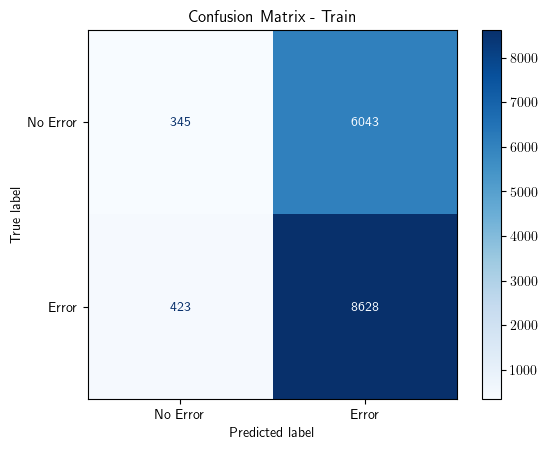

<Figure size 800x600 with 0 Axes>

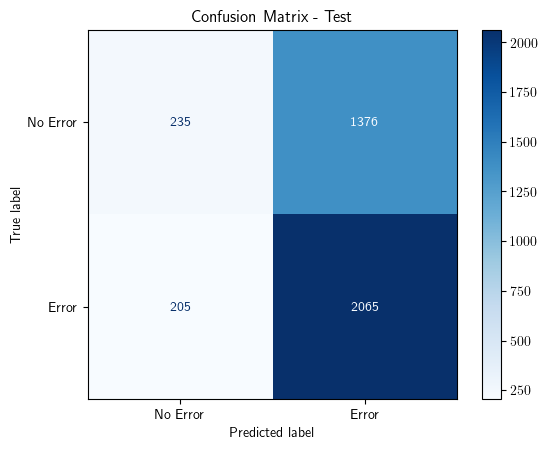

In [4]:
#Compute avg and std of accuracy, f1 and jaccard across folds as saved in the best model
LOSO_f1_train, LOSO_f1_test, LOSO_acc_train, LOSO_acc_test, LOSO_jaccard_train, LOSO_jaccard_test = ([] for _ in range(6))
LOSO_cm_train, LOSO_cm_test = (np.zeros((2, 2)) for _ in range(2))  #Init confusion matrices 

for out in outs:

    model_folder = f'models/{model.name}/' 
    model_path = os.path.join(model_folder, f'{setting}_{out}_model.pth')

    #Model file contains the state dicts along with performance at that epoch. with open does not work
    if os.path.exists(model_path):

        #with open(model_path, 'rb') as f: does not work. try alternative
        best_model = torch.load(model_path, map_location="cpu", weights_only=False)

        LOSO_f1_train.append(best_model['train_f1_fold'])
        LOSO_f1_test.append(best_model['test_f1_fold'])
        LOSO_acc_train.append(best_model['train_acc_fold'])
        LOSO_acc_test.append(best_model['test_acc_fold'])   
        LOSO_jaccard_train.append(best_model['train_jaccard_fold'])
        LOSO_jaccard_test.append(best_model['test_jaccard_fold'])
        LOSO_cm_train += best_model['train_cm_fold']
        LOSO_cm_test += best_model['test_cm_fold']
    
    else:
        print(f"Model file {model_path} does not exist. Skipping...")

#Change confusion matrices to integer type
LOSO_cm_train = LOSO_cm_train.astype(int)
LOSO_cm_test = LOSO_cm_test.astype(int)

#Create a summary df. Columns: f1, acc, jaccard. Index: Train, Test.
#Each entry is mean +- std format
summary_df = pd.DataFrame(index=['Train', 'Test'], columns=['F1', 'Accuracy', 'Jaccard'])
summary_df.loc['Train', 'F1'] = f"{np.mean(LOSO_f1_train):.2f} ± {np.std(LOSO_f1_train):.2f}"
summary_df.loc['Test', 'F1'] = f"{np.mean(LOSO_f1_test):.2f} ± {np.std(LOSO_f1_test):.2f}"
summary_df.loc['Train', 'Accuracy'] = f"{np.mean(LOSO_acc_train):.2f} ± {np.std(LOSO_acc_train):.2f}"
summary_df.loc['Test', 'Accuracy'] = f"{np.mean(LOSO_acc_test):.2f} ± {np.std(LOSO_acc_test):.2f}"
summary_df.loc['Train', 'Jaccard'] = f"{np.mean(LOSO_jaccard_train):.2f} ± {np.std(LOSO_jaccard_train):.2f}"
summary_df.loc['Test', 'Jaccard'] = f"{np.mean(LOSO_jaccard_test):.2f} ± {np.std(LOSO_jaccard_test):.2f}"


display(summary_df)

#Save summary df to csv
if not os.path.exists('results/SimpleLSTM'):
    os.makedirs('results/SimpleLSTM')
summary_df.to_csv('results/SimpleLSTM/LOSO_summary.csv')

if not os.path.exists('images/SimpleLSTM'):
    os.makedirs('images/SimpleLSTM')
    
print("Confusion Matrix for Train:")
#plot
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(LOSO_cm_train, display_labels=['No Error', 'Error']).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Train')
plt.savefig('images/SimpleLSTM/LOSO_Train_Confusion_Matrix.png')
print("Confusion Matrix for Test:")

plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(LOSO_cm_test, display_labels=['No Error', 'Error']).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test')
plt.savefig('images/SimpleLSTM/LOSO_Test_Confusion_Matrix.png')
